# Convolutional Neural Network

### Um simples problema de visão computacional é proposto para ilustrar um classificador de imagens baseado uma rede neural convolucional. Será elaborado um modelo de rede neural convolucional capaz de distinguir imagens de cachorros e gatos. Para isso será utilizada uma base de dados contendo milhares de imagens de gatos e cachorros ([Kaggle Cats and Dogs Dataset](https://www.kaggle.com/c/dogs-vs-cats)), que pode ser obtida no site da [Microsoft](https://www.microsoft.com/en-us/download/details.aspx?id=54765), para o treinamento e teste da rede neural.

### Bibliotecas a serem utilizadas

In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

### Coleta e pré-processamento dos dados

tensor([1., 0.])


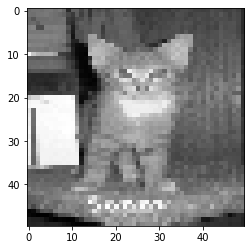

In [2]:
REBUILD_DATA = False
# classe para definição dos dados de treinamento
class DogsVSCats():
    IMG_SIZE = 50
    CATS = "PetImages/Cat"
    DOGS = "PetImages/Dog"
    TESTING = "PetImages/Testing"
    LABELS = {CATS: 0, DOGS: 1}
    training_data = []
    catcount = 0
    dogcount = 0
    def make_training_data(self):
        for label in self.LABELS:
            for f in tqdm(os.listdir(label)):
                if "jpg" in f:
                    try:
                        path = os.path.join(label, f) # caminho para os dados
                        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE) # imagens RBG transformadas em imagens grayscale
                        img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE)) # imagens serão 50x50 pixels
                        self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]]) # np.eye(2) -> identity matrix 2x2
                        # contagem de amostras 
                        if label == self.CATS:
                            self.catcount += 1
                        elif label == self.DOGS:
                            self.dogcount += 1
                        
                    except Exception as e:
                        pass
                    
        np.random.shuffle(self.training_data) # embaralha as amostras
        np.save('training_data.npy', self.training_data) # salva dados
        print('Cats:', self.catcount) # número de amostras com gatos
        print('Dogs', self.dogcount) # número de amostras com cachorros
        
if REBUILD_DATA:
    dogsvcats = DogsVSCats()
    dogsvcats.make_training_data()

# dado de treinamento  
training_data = np.load("training_data.npy", allow_pickle = True)
# dados de entrada armazenados em um tensor
X = torch.Tensor([i[0] for i in training_data]).view(-1,50,50)
# normalização dos pixels dos dados de entrada
X = X/255.0 
# respostas esperadas para os dados de entrada armazenados em um tensor
y = torch.Tensor([i[1] for i in training_data])

# exemplo de imagem
plt.imshow(X[0], cmap='gray')
print(y[0])

### Divisão dos dados para treinamento e para teste

In [3]:
VAL_PCT = 0.1 # 10% dos dados serão utilizados para teste
val_size = int(len(X)*VAL_PCT)
# divisão
# dados de treinamento
train_X = X[:-val_size]
train_y = y[:-val_size]
# dados de teste
test_X = X[-val_size:]
test_y = y[-val_size:]
print(len(train_X), len(test_X))

22452 2494


### Implementação do modelo de rede convolucional a ser aplicada para o problema
Opta-se pela implementação de uma rede neural de 3 camadas de convolução, uma camada de achatamento e uma camada de saída.

In [8]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # camada 1 de convolução
        self.conv1 = nn.Conv2d(1, 32, 5) # entrada: 1 imagem (50x50), 32 canais de saída, (5x5) kernel 
        # camada 2 de convolução
        self.conv2 = nn.Conv2d(32, 64, 5) # 32 entradas, 64 canais de saída, (5x5) kernel
        # camada 3 de convolução
        self.conv3 = nn.Conv2d(64, 128, 5) # 64 entradas, 128 canais de saída, (5x5) kernel
        
        # descobre a dimensão da resposta da terceira camada de convolução
        x = torch.randn(50,50).view(-1, 1, 50, 50)
        self.flatten_x_len = int(len(self.convs(x)))
        
        
        # camadas de unidades de processamento
        self.fc1 = nn.Linear(self.flatten_x_len, 512) # camada com 512 unidades de processamento
        self.fc2 = nn.Linear(512, 2) # camada com 2 unidades de saída (número de classes possíveis)
     
    # propagação forward nas camadas de convolução
    # entre cada camada de convolução aplica-se a função max pooling com janela (2x2)
    def convs(self, x):
        # max pooling over 2x2
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2)) # função max pooling com janela (2x2)
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2)) # função max pooling com janela (2x2)
        x = F.max_pool2d(F.relu(self.conv3(x)), (2,2)) # função max pooling com janela (2x2)
        # resposta da terceira camada de convolução é achatada para classificação da amostra
        x = torch.flatten(x) # flattening -> there is a torch.flatten(Tensor) function
        return x
    
    # propagação forward na rede neural
    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self.flatten_x_len)
        x = F.relu(self.fc1(x))
        x = self.fc2(x) # output layer
        return F.softmax(x, dim=1)

Iniciação da rede neural convolucional         

In [9]:
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)


Otimizador utilizado para treinamento da rede

In [10]:
optimizer = optim.Adam(net.parameters(), lr=0.001) # opta-se por utilizar o algoritmo Adam

Função erro para avaliar respostas geradas pela rede neural

In [11]:
loss_function = nn.MSELoss() # opta-se por utilizar a função de erro quadrado médio (MSELoss)

### Treinamento da rede neural

  0%|                                                  | 0/225 [00:00<?, ?it/s]

Epoch: 0. Loss: 0.196632519364357


  0%|                                                  | 0/225 [00:00<?, ?it/s]

Epoch: 1. Loss: 0.13888046145439148


100%|████████████████████████████████████████| 225/225 [01:57<00:00,  1.92it/s]


Epoch: 2. Loss: 0.10891798883676529


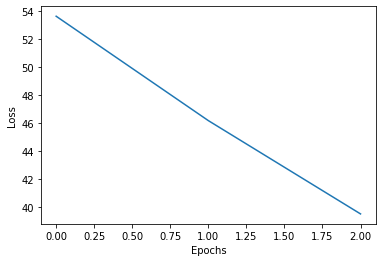

In [14]:
BATCH_SIZE = 100 # tamanho das bateladas de amostras a serem utilizadas no treinamento
EPOCHS = 3 # quantas passagens sobre todas as amostras de treinamento serão utilizadas
loss_log = []
for epoch in range(EPOCHS):
    loss_epoch = []
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)): # iteração de passagens forward e backward
        batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,50,50) # batelada de dados de entrada
        batch_y = train_y[i:i+BATCH_SIZE] # respostas esperadas para os dados de entrada
        # zera os gradientes da rede neural
        net.zero_grad()
        # propagação forward
        outputs = net(batch_X)
        # cálculo dos erros das respostas geradas pela rede neural para amostras de entradas
        loss = loss_function(outputs, batch_y)
        # propagação backward
        loss.backward()
        # ajuste dos parâmetros da rede neural 
        optimizer.step()
        # armazenamento dos erros das bateladas
        loss_epoch.append(loss.item())
    # armazenamento dos erros da passagem
    loss_log.append(sum(loss_epoch))  
    print(f"Epoch: {epoch}. Loss: {loss}")
# plot função erro x epochs
plt.plot(range(EPOCHS), loss_log)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

### Teste da rede neural 

In [15]:
correct = 0
total = 0
with torch.no_grad(): # desativa o cálculo de gradientes
    for i in tqdm(range(len(test_X))): # propagação dos dados de teste
        real_class = torch.argmax(test_y[i])
        net_out = net(test_X[i].view(-1,1,50,50))[0] # repostas geradas para os dados teste
        predicted_class = torch.argmax(net_out)
        # avaliação da acurácia do modelo
        if predicted_class == real_class:
            correct += 1
        total += 1
print("Accuracy: ", round(correct/total, 3))

100%|█████████████████████████████████████| 2494/2494 [00:23<00:00, 108.21it/s]

Accuracy:  0.75


### Exemplo de classificação

tensor([0.0683, 0.9317], grad_fn=<SelectBackward>)


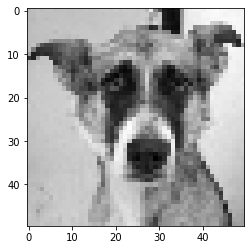

In [16]:
plt.imshow(test_X[0], cmap='gray')
print(net(test_X[0].view(-1,1,50,50))[0])

tensor([0.0856, 0.9144], grad_fn=<SelectBackward>)


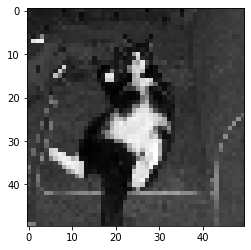

In [17]:
plt.imshow(test_X[100], cmap='gray')
print(net(test_X[100].view(-1,1,50,50))[0])

tensor([0.7943, 0.2057], grad_fn=<SelectBackward>)


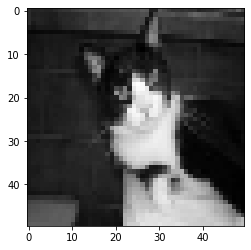

In [18]:
plt.imshow(test_X[200], cmap='gray')
print(net(test_X[200].view(-1,1,50,50))[0])